---
## Importing packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob

---
## Camera calibration

In [2]:
# Step 1: define the calibration function
def get_camera_calibration(calib_file):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,9,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    imgpoints = []
    objpoints = []
    # Make a list of calibration images
    images = glob.glob(calib_file)
    # Step through the list and search for chessboard corners
    img_calib_show = []
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)        
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            img_calib_show.append(img) # for visualization    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
            
    return mtx, dist

In [3]:
# Step 2: do the calibration using the images for calibration.
global mtx
global dist
mtx, dist = get_camera_calibration('./camera_cal/calibration*.jpg')

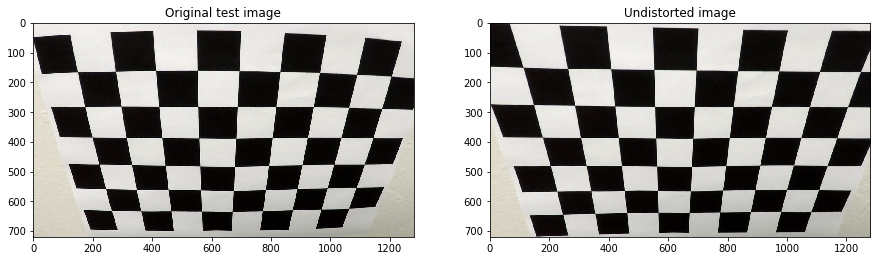

In [6]:
# test
img = plt.imread('./camera_cal/calibration2.jpg')# for debug
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original test image")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Undistorted image")
plt.savefig("output_images/calib_test.jpg")

---
## Pipeline(single images)

In [2]:
#====================camera_distortion_correction===================================
def camera_distortion_correction(img_name, mtx, dist):
    
    img = plt.imread(img_name)
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist
#===================thresholded_binary====================================
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1    
    return binary_output

def abs_sobel_thresh(img,sobel_kernel=3, orient='x',thresh=(0,255)):    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1, ksize=sobel_kernel)
    if orient=='x':
        sobel = sobelx
    elif orient=='y':
        sobel = sobely
    else:
        sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(sobel_scaled)
    binary_output[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
   
    return binary_output

def hls_select(img, s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return binary_output

def thresholded_binary(img,ksize = 5):        
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    gradxy = abs_sobel_thresh(img, orient='xy', sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    s_binary = hls_select(img, s_thresh=(160, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((gradxy == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1 
    
    return combined
#================birds-eye view transfer=======================================
def birds_eye_transfer(img,flag=1):
    '''
    img: binary image
    '''
    img_size = (img.shape[1], img.shape[0])
    offset = 90
    src = np.float32([[559,477],[280,680],[1035,680],[728,477]])
    dst = np.float32([[280+offset,330],[280+offset,680],[1035-offset,680],[1035-offset,330]])
    if flag==1:
        M = cv2.getPerspectiveTransform(src, dst)
    elif flag==2:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped
def region_of_interest(img):
    '''
    img: binary image
    '''
    shape = img.shape 
    vertices = np.array([[(90,shape[0]),(shape[1]-90,shape[0]),(shape[1]-570,420),(570,420)]],dtype=np.int32)
    mask = np.zeros_like(img)   
    ignore_mask_color = 255        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
#================get line inds & pixels=======================================
def get_start_points(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)    
    #plt.plot(histogram,'r-',MarkerSize = 18)    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram,leftx_base,rightx_base

def get_lane_inds(img,leftx_base,rightx_base,nwindows=9,margin=60,minpix = 50):
    out_img = np.dstack((img,img,img))*255
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 5) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
              
    return left_lane_inds,right_lane_inds

def detect_lane_pixels(img):
    '''img: birds-eye-view binary image'''        
    histogram,leftx_base,rightx_base = get_start_points(img)
    left_lane_inds,right_lane_inds = get_lane_inds(img,leftx_base,rightx_base,nwindows=9,margin=100,minpix = 50)
    
    return left_lane_inds,right_lane_inds

def lane_fit(img,lane_inds):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 
    fit = np.polyfit(y, x, 2)    
    return fit

def pixels_on_lane(img,left_lane_inds,right_lane_inds):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    left_fit = lane_fit(img,left_lane_inds)
    right_fit = lane_fit(img,right_lane_inds)    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
     
    return left_fitx,right_fitx,ploty
#================get curvature & offset=======================================
def get_curvature(left_fitx,right_fitx,ploty,imshape):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad,right_curverad

def get_offset(left_lane_inds,right_lane_inds,imshape):
    left_fit = lane_fit(img,left_lane_inds)
    right_fit = lane_fit(img,right_lane_inds)
    xm_per_pix = 3.7/700
    offset = (imshape[1]/2.0-(np.poly1d(left_fit)(1.0)+ np.poly1d(right_fit)(1.0))/2.0)*xm_per_pix*100
    
    print('vehicle offset to the center:',offset, 'cm')
    
    return offset
#================show boundaries=======================================
def show_boundaries(img_orig,img_perspective_trans,left_fitx,right_fitx,ploty):
    warp_zero = np.zeros((img_perspective_trans.shape[0],img_perspective_trans.shape[1])).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
        
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = birds_eye_transfer(color_warp,flag=2)    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1.0, newwarp, 0.6, 0)
    
    return result
#================visual display=======================================
def visual_display(img,video,left_curverad,right_curverad,offset):
    if video:
        # Add text information on the video frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_pos = 'Pos of the car: '+str(np.round(offset))+ ' cm'+'(+ right)'
        radius = np.round(left_curverad+right_curverad,2)
        if radius >= 10000:
            radius = 'Inf'
        else:
            radius = str(radius)
        text_rad = 'Radius: '+radius+ ' m'
        cv2.putText(img,text_pos,(10,25), font, 1,(255,255,255),2)
        cv2.putText(img,text_rad,(10,75), font, 1,(255,255,255),2)
        return img  

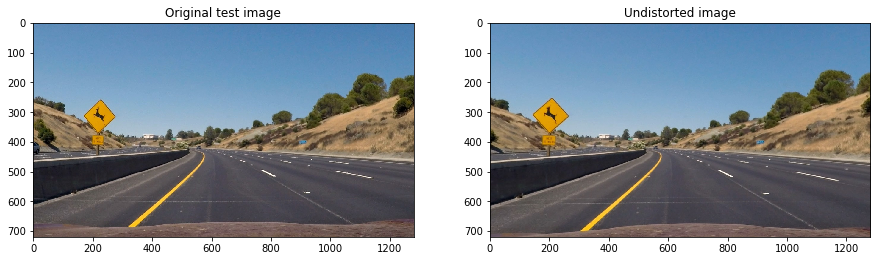

In [68]:
# Step 1
img = plt.imread('./test_images/test2.jpg')# for debug
imshape = img.shape

img_undist = camera_distortion_correction('./test_images/test2.jpg', mtx, dist)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original test image")
#plt.savefig("output_images/OriginalTestImage.jpg")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Undistorted image")
#plt.savefig("output_images/img_undist.jpg")

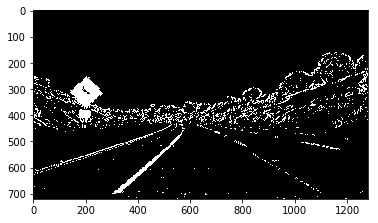

In [69]:
# Step2
img_thresholded_binary = thresholded_binary(img_undist,ksize = 5)
plt.imshow(img_thresholded_binary,cmap = 'gray')
#plt.savefig("output_images/img_thresholded_binary.jpg")

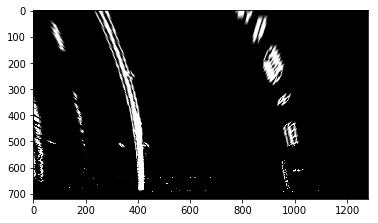

In [70]:
# Step3
img_perspective_trans = birds_eye_transfer(img_thresholded_binary,flag=1)
plt.imshow(img_perspective_trans,cmap = 'gray')
#plt.savefig("output_images/img_perspective_trans.jpg")

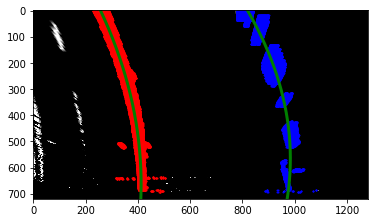

In [71]:
# Step4
left_lane_inds,right_lane_inds = detect_lane_pixels(img_perspective_trans)
left_fitx,right_fitx,ploty = pixels_on_lane(img_perspective_trans,left_lane_inds,right_lane_inds)
plt.imshow(img_perspective_trans,cmap = 'gray')
mark_size = 1
nonzero = img_perspective_trans.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

plt.plot(nonzerox[left_lane_inds], nonzeroy[left_lane_inds], 'o', color='red', markersize=mark_size)
plt.plot(nonzerox[right_lane_inds], nonzeroy[right_lane_inds], 'o', color='blue', markersize=mark_size)

plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
#plt.savefig("output_images/lane_boundary.jpg")
#plt.gca().invert_yaxis() 

In [72]:
# Step5
left_curverad,right_curverad = get_curvature(left_fitx,right_fitx,ploty,imshape)
offset = get_offset(left_lane_inds,right_lane_inds,imshape)

464.591667549 m 321.600568767 m
vehicle offset to the center: 4.32833649441 cm


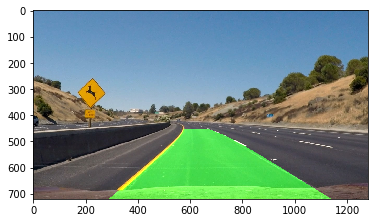

In [73]:
# Step6
masked_img = show_boundaries(img_undist,img_perspective_trans,left_fitx,right_fitx,ploty)
plt.imshow(masked_img)
#plt.savefig("output_images/masked_img.jpg")

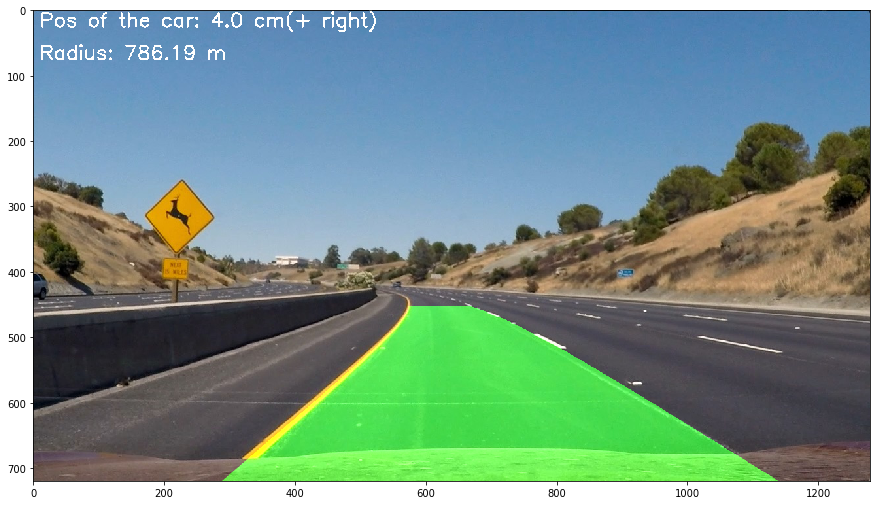

In [74]:
# Step7
final_img = visual_display(masked_img,1,left_curverad,right_curverad,offset)
plt.figure(figsize=(15,15))
plt.imshow(final_img)
#plt.savefig("output_images/final_img8.jpg")